<a href="https://colab.research.google.com/github/corwindark/5000-lab-1.2/blob/main/dl_ens_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Setup - Run Every Time

In [ ]:
# TENSORFLOW
import tensorflow as tf
print("TENSORFLOW VERSION:",tf.__version__)

# PYTORCH
import torch
print("PYTORCH VERSION:",torch.__version__)

# KERAS
import keras;
print("KERAS VERSION:",keras.__version__)

TENSORFLOW VERSION: 2.15.0
PYTORCH VERSION: 2.2.1+cu121
KERAS VERSION: 2.15.0


In [ ]:
print(torch.cuda.is_available())

False


In [ ]:
# GET SYSTEM INFO
# code modified from: https://stackoverflow.com/questions/110362/how-can-i-find-the-current-os-in-python

import platform
import multiprocessing
import sys
import psutil

def linux_distribution():
  try:
    return platform.linux_distribution()
  except:
    return "N/A"

def dist():
  try:
    return platform.dist()
  except:
    return "N/A"

num_cores=multiprocessing.cpu_count()

print("""
Python version: %s
dist: %s
num_cores: %s
linux_distribution: %s
system: %s
machine: %s
platform: %s
uname: %s
version: %s
RAM: %s
""" % (
sys.version.split('\n'),
str(dist()),
num_cores,
linux_distribution(),
platform.system(),
platform.machine(),
platform.platform(),
platform.uname(),
platform.version(),
psutil.virtual_memory().total*10**(-9.)
))

# print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))


Python version: ['3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]']
dist: N/A
num_cores: 2
linux_distribution: N/A
system: Linux
machine: x86_64
platform: Linux-6.1.58+-x86_64-with-glibc2.35
uname: uname_result(system='Linux', node='e72e12c4d338', release='6.1.58+', version='#1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023', machine='x86_64')
version: #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
RAM: 13.609443328000001



In [ ]:
torch.cuda.device_count()
torch.cuda.get_device_properties(0).total_memory

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers.legacy import RMSprop, Adam
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import time
from datetime import timedelta
from sklearn.model_selection import KFold
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
pd.options.mode.chained_assignment = None



In [ ]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "statsforecast"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "dexplot"])

0

In [ ]:
import dexplot as dxp
from statsforecast import StatsForecast
from statsforecast.models import AutoCES, AutoARIMA, AutoETS, DynamicOptimizedTheta
import numpy as np
import time



```
# This is formatted as code
```

# New DL Functions

In [ ]:
# Getting more different financial datasets

def prep_ticker(ticker, start_date = '2022-06-01', end_date = '2023-09-30', intervals = '60m', split = True, train_size = 2000):
  # this function was written for the use of Yfinance data, which is no longer a part of the project, but included for completion
  data = yf.download(ticker,start_date, end_date, interval = intervals)

  #print(data.head)

  # reset index names
  data.reset_index(inplace = True)

  if split == True:

    # split data into train and test
    data_train = data[:train_size]
    data_test = data[train_size:]

    test_size = len(data_test)


    # only store closing prices
    data_test = data_test[["Datetime", "Close"]]
    data_train = data_train[["Datetime", "Close"]]

    seriesTrain = data_train.set_index('Datetime')
    seriesTest = data_test.set_index('Datetime')


    # return the data in series format with datetime
    return seriesTrain, seriesTest

  elif split == False:

    # if data is not desired in train test, do the same steps but without splitting
    data_out = data

    data_out = data_out[["Datetime", "Close"]]

    seriesOut = data_out.set_index('Datetime')


    return seriesOut




In [ ]:

# These functions provide the output of statistical models that we ensemble alongside our neural network

# Auto arima model is fit on the slice of data , and returns predictions
def new_aaPredFunction(dataIn, windowSize):
    model = AutoARIMA()
    fit1 = model.fit(dataIn)
    prediction = fit1.predict(h = windowSize)
    return prediction.get('mean')

# Complex exponential smoothing is fit on the slice of data , and returns predictions
def new_cesPredFunction(dataIn, windowSize):
    model = AutoCES()
    fit1 = model.fit(dataIn)
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

# Exponential smoothing is fit on the slice of data , and returns predictions
def new_etsPredFunction(dataIn, windowSize):
    model = AutoETS()
    fit1 = model.fit(dataIn)
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

# Dynamic Optimized thera model is fit on the slice of data , and returns predictions
def new_dotPredFunction(dataIn, windowSize):
    model = DynamicOptimizedTheta()
    fit1 = model.fit(dataIn)
    predictionList = fit1.predict(windowSize)
    return predictionList.get('mean')

In [ ]:
def stat_true_window_cross_val(unsplitdata, model_names, predReturnFunctions, train_window = 10, test_window = 1, nn_task = 'regression', verbose = False):
    # compute how many values we will predict, given the forward and backward window
    totalPredictions = pd.Series(dtype = 'float64')
    windows = len(unsplitdata) // (train_window + test_window)
    columns = train_window + (test_window * (1 + len(model_names)))

    # generate dataframe to hold predictions
    pred_df = np.zeros([windows, columns])
    print(pred_df.shape)

    #
    unsplitdata = np.array(unsplitdata)
    unsplitdata = unsplitdata.reshape((unsplitdata.shape[0],))
    print(unsplitdata.shape)

    print("Window num:", windows)

    # indexes loop through the data
    predictionIndex = 0
    startindex = 0

    start_time = time.perf_counter()

    for i in range(0, windows):

        #print(time.clock() - start_time, "seconds")


        if i > 0 and i == 200 and verbose == True:

          duration = timedelta(seconds=time.perf_counter()-start_time)
          print("Seconds elapsed for first ", i, ": ", duration)
          print("Total est time based on window num = ", ((windows / i) * duration))

        # debug
        #print("Window: ", i)

        train_window_dat = unsplitdata[startindex:(startindex+train_window)]
        #print(train_window_dat)
        test_window_dat = unsplitdata[(startindex+train_window ): (test_window + startindex+train_window)]

        startindex = startindex + train_window + test_window

        #print(pred_df[i,0:train_window])
        #print(pred_df[i,0:train_window].shape)

        #print(train_window_dat.shape)
        #print( train_window_dat.reshape((train_window,)).shape)

        pred_df[i,0:train_window] = np.reshape(train_window_dat, [train_window])
        pred_df[i,(train_window):(train_window + test_window)] = test_window_dat

        for modnum, modelfunction in enumerate(predReturnFunctions):
          # account for how many columns in output array over to shift for this model
          # add 1 to fit the real values
          #print(modnum)
          offset = ((modnum + 1) * test_window) + train_window

          # Generate prediction of the given window size
          prediction = modelfunction(train_window_dat, test_window)
          #print(prediction[0])

          # Check if we have multiple predictions in the window
          if len(prediction) > 1:
              # Store each predicted value with a loop
              for j in range(0,test_window):

                  # Store in the prediction-comparison frame
                  pred_df[i,j + offset] = prediction[j]

          else:

              pred_df[i,offset] = prediction[0]

    # currently configured to split up data into 3 matrices instead of returning together
    x_windows = pred_df[:,0:train_window]
    real_ys = pred_df[:,train_window:(train_window + test_window)]
    stat_preds = pred_df[:,(train_window + test_window):(columns+1) ]


    #print(pred_df)

    return x_windows, real_ys, stat_preds


In [ ]:
# in an effort to speed up model compute time, we will move to pre-calculating all of the statistical model forecasts
# these can then be included in the function directly, and read in from the drive file
# naming convention for this data is [ticker][year][increment][intervalval]_b[windowback]_f[predictionwindow]_[modelinitials]
# ticker = SPY/BRENT/BTC/VIX/EUR
# modelinitals = A-Arima, D-Dynamic Optimized Theta, C = Complex Exponential Smoothing, E = Auto Exponential Smoothing
#   order of model intials tells you order that data is stored in columns
# example: SPY2023min5_b10_f1_AC
#from google.colab import drive
#drive.mount('/content/drive')

#spyFullmin5 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/spy2023min5.csv")
#seriesIn = pd.Series(spyFullmin5['close'])


In [ ]:
#ticker_mean = seriesIn.mean()
#ticker_std = seriesIn.std()
#seriesIn = (seriesIn - ticker_mean) / ticker_std

In [ ]:
#xs,ys,preds = stat_true_window_cross_val(seriesIn, ['auto_arima','complex_smoothing', 'dyn_theta', 'auto_ets'], [new_aaPredFunction, new_cesPredFunction, new_dotPredFunction, new_etsPredFunction], train_window = 100, test_window = 1, verbose = True)


In [ ]:
#preds = pd.DataFrame(preds)

#preds.to_csv('/content/drive/MyDrive/Colab Notebooks/spy2023min5_b100_f1_ACDE.csv', index = False, header =  ['auto_arima','complex_smoothing', 'dyn_theta', 'auto_ets'])

In [ ]:
def history_plot(history):
    FS=18   #FONT SIZE
    # PLOTTING THE TRAINING AND VALIDATION LOSS
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validationy loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
def calculate_metrics(window_size, real_data, stat_pred, nn_pred):
    # declare values we will calculate when looping through the real data
    stat_avg_mse, nn_mse, nn_avg_mse = 0,0,0
    # find out how many stat models are in the ensemble
    num_stat_mods = int(stat_pred.shape[1] / window_size)

    print(num_stat_mods)

    for row in range(0, real_data.shape[0]):
      for obs in range(0,real_data.shape[1]):

        # real value
        rv = real_data[row,obs]

        # squared error for neural network model
        nn_mse += (rv - nn_pred[row,obs]) ** 2

        # numerator for stat model avg
        stat_numerator = 0

        for mod in range(0,num_stat_mods):
          # add each models prediction for the given datapoint
          stat_numerator += stat_pred[row,obs + (mod*window_size)]

        # numerator for the stat+NN ensemble
        nn_stat_numerator = stat_numerator + nn_pred[row,obs]

        # find the ensemble prediction for the datapoint
        stat_avg = stat_numerator / num_stat_mods
        nn_stat_avg = nn_stat_numerator / (num_stat_mods + 1)

        # calculate the squared error for these ensembles
        stat_avg_mse += (rv - stat_avg) ** 2
        nn_avg_mse += (rv - nn_stat_avg) ** 2

    # find mean square error instead of total
    n_obs = real_data.shape[0]
    nn_mse = nn_mse / n_obs
    stat_avg_mse = stat_avg_mse / n_obs
    nn_avg_mse = nn_avg_mse / n_obs

    return stat_avg_mse, nn_mse, nn_avg_mse



In [ ]:
def full_single_nn_wrapper2(
    nn_modeltype,
    nn_task,
    train_split,
    ticker,
    stopping,
    model_names = ['auto_arima','complex_smoothing'],
    predReturnFunctions = [new_aaPredFunction, new_cesPredFunction],
    start_date_in = '2022-06-01',
    end_date_in = '2023-09-30',
    interval_in = '60m',
    split = False,
    train_size = 2000,
    train_window = 10,
    test_window = 1,
    epochs_in = 50,
    verbose = 1,
    LR = 0.0005,
    yfinance = True):

  # use inputs to get stock data of the requested format
  if yfinance == True:

    ticker_data = prep_ticker(ticker, intervals = interval_in, start_date = start_date_in, end_date = end_date_in, split = split)

  elif yfinance == False:
    ticker_data = ticker.copy()

  # difference data to test if it makes a 'difference'
  # update, differenced data seems to break auto CES
  #ticker_data = ticker_data.diff()

  # normalize data
  ticker_mean = ticker_data.mean()
  ticker_std = ticker_data.std()
  ticker_data = (ticker_data - ticker_mean) / ticker_std

  # break stock data into windows and return statistical model predictions
  xs,ys,preds = stat_true_window_cross_val(ticker_data, model_names, predReturnFunctions, train_window, test_window)

  # calculate train test split
  train_obs = round(xs.shape[0] * train_split)

  if nn_task == "regression":

    # divide matrices
    x_train_dat = xs[0:train_obs,:]
    x_val_dat = xs[train_obs:xs.shape[0],:]
    y_train_dat = ys[0:train_obs,:]
    y_val_dat = ys[train_obs:ys.shape[0],:]
    stat_train = preds[0:train_obs,:]
    stat_val = preds[train_obs:preds.shape[0],:]

  if nn_task == "classification":

    # generate categorical outcome data (which model was optimal) if task is classification
    # only works with 1-ahead windows for now
    stat_model_number = len(model_names)
    y_optimals = np.zeros(shape = [ys.shape[0], stat_model_number])

    #iterate through the occurences to find optimal model in the ensemble in each
    errors = np.zeros(shape = preds.shape)
    for i in range(0, y_optimals.shape[0]):
      yval = ys[i,0]
      #print("error shape: ", errors.shape)
      for j in range(0, errors.shape[1]):
        errors[i,j] = yval - preds[i,j]

      y_optimals[i, np.argmin(errors[i,:], axis=0)] = 1

    # divide matrices, saving both cateogrical and regression info
    x_train_dat = xs[0:train_obs,:]
    x_val_dat = xs[train_obs:xs.shape[0],:]
    y_train_dat = y_optimals[0:train_obs,:]
    y_train_reg_real = ys[0:train_obs,:]
    y_val_dat = y_optimals[train_obs:ys.shape[0],:]
    y_val_reg_real = ys[train_obs:ys.shape[0],:]
    stat_train = preds[0:train_obs,:]
    stat_val = preds[train_obs:preds.shape[0],:]


  """    print("val optimals: ")
    print(y_val_dat[0:5,:])
    print("val real")
    print(y_val_reg_real[0:5,:])
    print("stat val")
    print(stat_val[0:5,:])
    print("errors")
    print(errors[0:5,:])
  """

  print("Train obs: ", x_train_dat.shape[0], "Val Obs:", x_val_dat.shape[0])

  # train-test split
  if verbose == 1:

    print("TRAIN SHAPE: ", x_train_dat.shape)
    print("VAL SHAPE: ", x_val_dat.shape)




  # set up neural network for the given data

  # Include stat preds into the data (will be for one type of CV and included in if-statement later)
  x_train_dat = np.concatenate([x_train_dat, stat_train], axis = 1)
  x_val_dat = np.concatenate([x_val_dat, stat_val], axis = 1)




  # declare a sequential model
  model = Sequential()

  if nn_modeltype == "feedforward" and nn_task == "regression":

    # create a simple linear feed forward model
    model.add(layers.Dense(32, activation='relu',input_shape=[x_train_dat.shape[1],]))
    # This layer is the recurent layer, which returns all previous data
    model.add(layers.Dense(128, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))

    # layer that reads the recurent layer
    model.add(layers.Dense(y_train_dat.shape[1]))
    model.compile(optimizer=RMSprop(learning_rate = LR), loss='mse')

  if nn_modeltype == "feedforward" and nn_task == "classification":
    cce = keras.losses.CategoricalCrossentropy()

    # create a simple linear feed forward model
    model.add(layers.Dense(32, activation='relu',input_shape=[x_train_dat.shape[1],]))
    # This layer is the recurent layer, which returns all previous data
    model.add(layers.Dense(64, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2)))

    # layer that reads the recurent layer
    model.add(layers.Dense(y_train_dat.shape[1], activation = "softmax"))
    model.compile(optimizer=RMSprop(learning_rate = LR), loss=cce)



  # run NN model
  test_one = model.fit(x = x_train_dat,
                      y = y_train_dat,
                      steps_per_epoch = x_train_dat.shape[0],
                      epochs= epochs_in,
                      batch_size = 1,
                      validation_data= (x_val_dat, y_val_dat),
                      callbacks=[stopping],
                      validation_steps= x_val_dat.shape[0],
                      verbose = 1)
  # print plot training graph
  if verbose == 1:
    history_plot(test_one)

  # get NN predictions
  nn_preds = model.predict(x_val_dat)

  print("NN pred shape", nn_preds.shape)
  print("Y Shape Uncollapsed", y_val_dat.shape )


  if nn_task == "regression":

    stat_avg_mse, nn_mse, nn_avg_mse = calculate_metrics(test_window, y_val_dat, stat_val, nn_preds)

    # take the most recent x observation and predict it again
    xval  = xs[train_obs:xs.shape[0],]
    nochange_pred = xval[:,(xs.shape[1]-1)]
    # take the diff from obs before last to last obs and make that diff again
    linearstep_pred = nochange_pred + (nochange_pred - (xval[:,(xs.shape[1]-2)]))
    # predict the average of last 5 points
    meanreversion_pred = np.mean(xval[:,0:6], axis = 1)


    print("STAT VAL ENSEMBLE MSE: ", stat_avg_mse)
    print("NN VAL MODEL MSE: ", nn_mse)
    print("NN+STAT VAL ENSEMBLE MSE: ", nn_avg_mse)
    print("NO CHANGE MSE:", mean_squared_error(y_val_dat, nochange_pred))
    print("Linear Change MSE:", mean_squared_error(y_val_dat, linearstep_pred))
    print("Mean Pred MSE:", mean_squared_error(y_val_dat, meanreversion_pred))

    return stat_avg_mse, nn_mse, nn_avg_mse

  # for classification tasks, turn optimal model prediction (categorical) back into regression prediction
  if nn_task == "classification":
    print("unedited preds")
    print(nn_preds[0:5,])

    real_preds = np.zeros(shape = [nn_preds.shape[0],1])
    for row in range(0,nn_preds.shape[0]):

      real_preds[row,0] = stat_val[row, np.argmax(np.absolute(nn_preds[row,:]), axis=0)]

    nn_preds = real_preds


    print("Y Shape Reshapen", nn_preds.shape)
    print(nn_preds[0:5])
    print("Stat Preds")
    print(stat_val[0:5,:])
    print("Real Ys")
    print(y_val_reg_real[0:5])

    stat_avg_mse, nn_mse, nn_avg_mse = calculate_metrics(test_window, y_val_reg_real, stat_val, nn_preds)


    print("STAT VAL ENSEMBLE MSE: ", stat_avg_mse)
    print("NN VAL MODEL MSE: ", nn_mse)
    print("NN+STAT VAL ENSEMBLE MSE: ", nn_avg_mse)


    return stat_avg_mse, nn_mse, nn_avg_mse

In [ ]:
def simple_windows(unsplitdata, train_window = 10, test_window = 1):

    # this function returns clean numpy arrays of the desired shape


    # smilar to previous version of the function, it calculates shape of output windows/forward predictions
    totalPredictions = pd.Series(dtype = 'float64')
    windows = len(unsplitdata) // (train_window + test_window)
    columns = train_window + test_window

    pred_df = np.zeros([windows, columns])
    print(pred_df.shape)



    unsplitdata = np.array(unsplitdata)
    unsplitdata = unsplitdata.reshape((unsplitdata.shape[0],))
    print(unsplitdata.shape)

    print("Window num:", windows)

    # indexes loop through the data
    predictionIndex = 0
    startindex = 0

    start_time = time.perf_counter()

    for i in range(0, windows):

        # build windows
        train_window_dat = unsplitdata[startindex:(startindex+train_window)]
        test_window_dat = unsplitdata[(startindex+train_window ): (test_window + startindex+train_window)]

        startindex = startindex + train_window + test_window

        pred_df[i,0:train_window] = np.reshape(train_window_dat, [train_window])
        pred_df[i,(train_window):(train_window + test_window)] = test_window_dat


    # currently configured to split up data into 3 matrices instead of returning together
    x_windows = pred_df[:,0:train_window]
    real_ys = pred_df[:,train_window:(train_window + test_window)]

    return x_windows, real_ys


In [ ]:
def build_model(model_dictlist, input, output):

  model = Sequential()

  for i, entry in enumerate(model_dictlist):

    if i == 0:
      # add correct input size if it's the first layer
      model.add(layers.Dense(entry['size'], activation=entry['act'],input_shape=input))
    elif  i == len(model_dictlist)-1:
      # add correct output size if it's the last layer
      model.add(layers.Dense(output))
    else:
      # otherwise just add a regular dense layer
      if entry['reg'] == False:
        model.add(layers.Dense(entry['size'], activation=entry['act']))
      else:
        model.add(layers.Dense(entry['size'], activation=entry['act'], kernel_regularizer = entry['reg']))

  print(model.summary)
  return model


In [ ]:

def nn_kfold(nn_model_dictlist, compile_params, fit_params, folds, xdat, ydat, statpreds, trainratio = 0.5, sametrainsize = False, classification = False, control = False):
  # this function fits a NN model over K folds, and returns average performance stats
  # it does not randomly assign, but rather adds increasingly more data to model
  # splits data into K+1 folds (as we cannot use the first fold as validation since no data proceedes it)
  # control decides whether stat models are included as predictors for the data

  # divisions are the folds + 1
  divs = folds + 1

  # get size of each fold
  fold_size = xdat.shape[0] // divs

  # print number of obs that will be clipped
  print("Folds will clip: ", xdat.shape[0] - (fold_size * divs), " obs")

  # initialize the model stats we will return
  train_mse = []
  train_mse_history = []
  val_mse = []
  val_mse_history = []

  # keep track of sliding windows
  #train_start = 0
  #val_start = fold_size
  #val_end = fold_size * 2

  fold_start = 0
  fold_end = fold_size
  train_end = math.floor(fold_size * trainratio)


  # combine xdata with statpreds
  print("X Data Shape: ", xdat.shape)
  if control == False:
    xdat = np.concatenate((xdat, statpreds), axis = 1)
  print("X Data Shape after joining statpreds: ", xdat.shape)

  foldsizes = []

  for i in range(0,folds):

    # this section decides whether each fold adds in more data or not (ie. keeps building training window)
    x_train_fold = []
    y_train_fold = []

    if sametrainsize == True:
      # if all folds are supposed to be the same, don't start at beginning of dataset
      x_train_fold  = xdat[fold_start:train_end,:]
      y_train_fold = ydat[fold_start:train_end]
    elif sametrainsize == False:
      # otherwise, start from zero
      x_train_fold = xdat[0:train_end,:]
      y_train_fold = ydat[0:train_end]

    x_val_fold = xdat[train_end:fold_end,:]
    y_val_fold = ydat[train_end:fold_end]

    # debug printing
    print("Fold: ", i, " Train shape: ", x_train_fold.shape[0], " Val Shape: ", x_val_fold.shape[0] )
    # save fold size for plot
    foldsizes.append(x_train_fold.shape[0])

    #print("First train obs: ", x_train_fold[0,:], "First Val obs: ", x_val_fold[0,:])
    # HARD CODED FOR 1-Step AHEAD at the moment
    foldModel = build_model(nn_model_dictlist, [x_train_fold.shape[1],], 1)

    # use compile dictionary to compile the model as desired
    foldModel.compile(optimizer = compile_params['optimizer'], loss = compile_params['loss'])

    modelOut = foldModel.fit(x = x_train_fold,
                      y = y_train_fold,
                      steps_per_epoch = 1,
                      epochs= fit_params['epochs'],
                      batch_size = x_train_fold.shape[0],
                      validation_data= (x_val_fold, y_val_fold),
                      callbacks= fit_params["callback"],
                      validation_batch_size = x_val_fold.shape[0],
                      validation_steps= 1,
                      verbose = fit_params['verbose'])

    hist = modelOut.history


    train_mse.append(hist['loss'][len(hist['loss'])-1])
    val_mse.append(hist['val_loss'][len(hist['val_loss'])-1])


    train_mse_history.append([hist['loss']])
    val_mse_history.append([hist['val_loss']])

    tf.keras.backend.clear_session()

    # update window values for next fold
    fold_end += fold_size
    fold_start += fold_size
    train_end += fold_size

    # plot fold performance by quantile
    # function


  plt.figure(0)
  plt.rcParams['font.size'] = 14
  plt.title("Validation MSE")
  for i, history in enumerate(val_mse_history):
      #print(history)
      plt.plot(range(0,len(history[0])),history[0], label = ("Fold: " + str(i) + " N: " + str(foldsizes[i]) ) )
  plt.yscale('log')
  plt.ylabel("MSE Error")
  plt.xlabel("Epoch")
  plt.title("Validation Error by Epoch")
  plt.legend()

  plt.figure(1)
  plt.title("Train MSE")
  for i, history in enumerate(train_mse_history):
      #print(history)
      plt.plot(range(0,len(history[0])),history[0], label = ("Fold: " + str(i) + " N: " + str(foldsizes[i])) )
  plt.yscale('log')
  plt.legend()
  #train_mse_history = np.divide(train_mse_history, fit_params['epochs'])

  print("Val Loss: ", sum(val_mse)/len(val_mse), "Train Loss: ", sum(train_mse)/len(train_mse))
  #plt.plot(range(0,fit_params['epochs']),train_mse_history)
  #ax = plt.gca()
  #ax.set_ylim([0, 0.1])
  plt.yscale("log")





In [ ]:
def evaluate_nn_architecture(nn_model_dictlist, compile_params, fit_params, xtrain, ytrain, xtest, ytest, stattrain, stattest, windowsize, control = False):
    # this function is used to test a given neural network model architecture


    # PUT BEFORE STAT OBS ARE CONCATENATED SO THEY USE TIME SERIES DATA
    # take the most recent x observation and predict it again
    # nondifferenced - nochange_pred = xtest[:,(xtest.shape[1]-1)]
    nochange_pred = np.zeros(shape = [xtest.shape[0],1])
    # take the diff from obs before last to last obs and make that diff again
    # nondifferenced - linearstep_pred = nochange_pred + (nochange_pred - (xtest[:,(xtest.shape[1]-2)]))
    linearstep_pred = xtest[:,(xtest.shape[1]-1)]
    # predict the average of last 5 points
    # nondifferenced = meanreversion_pred = np.mean(xtest[:,:-6], axis = 1)
    meanreversion_pred = np.mean(xtest[:,:-6], axis = 1)

    # use control parameter to decide whether to include stat model predictions
    if control == False:
      xtrain = np.concatenate((xtrain, stattrain), axis = 1)
      xtest = np.concatenate((xtest, stattest), axis = 1)

    foldModel = build_model(nn_model_dictlist, [xtest.shape[1],], 1)



    # use compile dictionary to compile the model as desired
    foldModel.compile(optimizer = compile_params['optimizer'], loss = compile_params['loss'])

    modelOut = foldModel.fit(x = xtrain,
                      y = ytrain,
                      steps_per_epoch = 1,
                      epochs= fit_params['epochs'],
                      batch_size =  xtrain.shape[0],
                      callbacks= fit_params["callback"],
                      verbose = fit_params['verbose'])

    test_full_preds = foldModel.predict(xtest)

    stat_avg_mse, nn_mse, nn_avg_mse = calculate_metrics(window_size = windowsize, real_data = ytest, stat_pred = stattest, nn_pred = test_full_preds)


    #plt.plot(np.subtract(test_full_preds, nochange_pred ), np.subtract(ytest, nochange_pred))




    print("STAT VAL ENSEMBLE MSE: ", stat_avg_mse)
    print("NN VAL MODEL MSE: ", nn_mse)
    print("NN+STAT VAL ENSEMBLE MSE: ", nn_avg_mse)
    print("NO CHANGE MSE:", mean_squared_error(ytest, nochange_pred))
    print("Linear Change MSE:", mean_squared_error(ytest, linearstep_pred))
    print("Mean Pred MSE:", mean_squared_error(ytest, meanreversion_pred))


    return(ytest, test_full_preds, nochange_pred)

# New DL Examples


In [ ]:
# Prep X/Y Data
spyFullmin5 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/spy2023min1.csv")
seriesIn = pd.Series(spyFullmin5['close'])


# convert to  pct changes
seriesIn = (seriesIn - seriesIn.shift(1)) / seriesIn

# standardize
ticker_mean = seriesIn.mean()
ticker_std = seriesIn.std()
seriesIn = (seriesIn - ticker_mean) / ticker_std


In [ ]:
print(spyFullmin5.head())

       timestamp     open     high      low    close  volume   {
0  1/3/2023 4:00  378.245  380.226  378.195  380.022   12663 NaN
1  1/3/2023 4:01  380.057  380.364  379.958  380.180    4000 NaN
2  1/3/2023 4:02  380.254  380.453  380.204  380.278    2000 NaN
3  1/3/2023 4:03  380.343  380.669  380.283  380.623    2702 NaN
4  1/3/2023 4:04  380.658  380.758  380.608  380.682    2097 NaN


Text(0.5, 1.0, 'Minute-Level Price of SPY 1/3/2021')

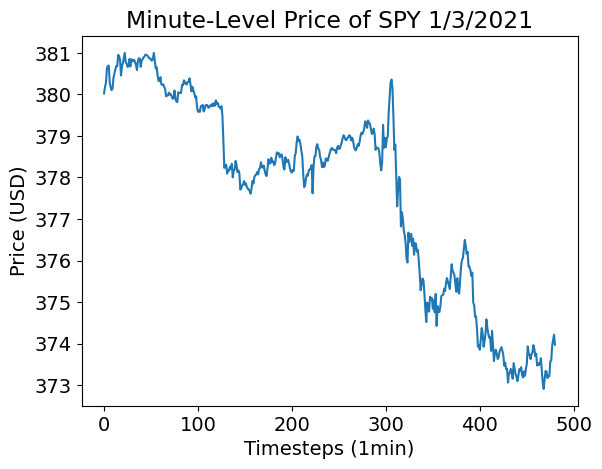

In [ ]:
# TEMPORARY CODE TO MAKE A PLOT

closePlot = pd.Series(spyFullmin5['close'])
closePlot = closePlot[0:481]

plt.rcParams['font.size'] = 14


plt.figure()
plt.plot(closePlot)
plt.xlabel("Timesteps (1min)")
plt.ylabel("Price (USD)")
plt.title("Minute-Level Price of SPY 1/3/2021")



In [ ]:
xdat, ydat = simple_windows(seriesIn, train_window = 10, test_window = 1)
print(xdat.shape)
print(ydat.shape)

(20578, 11)
(226362,)
Window num: 20578
(20578, 10)
(20578, 1)


In [ ]:
statpredsIn = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/spy2023min1_b10_f1_ACDE.csv")
statpredsIn = statpredsIn.to_numpy()

In [ ]:
statpredsIn = statpredsIn[:,0:2]

In [ ]:
from sklearn.preprocessing import normalize

statpredsIn = normalize(statpredsIn, axis=0, norm = 'max')


Folds will clip:  3  obs
X Data Shape:  (14403, 10)
X Data Shape after joining statpreds:  (14403, 14)
Fold:  0  Train shape:  1920  Val Shape:  480
<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7935f79baa10>>
Epoch 1/200
1/1 [==============================] - 1s 704ms/step - loss: 2.2350 - val_loss: 2.0863
Epoch 2/200
1/1 [==============================] - 0s 46ms/step - loss: 2.3947 - val_loss: 1.8834
Epoch 3/200
1/1 [==============================] - 0s 51ms/step - loss: 2.1879 - val_loss: 1.6903
Epoch 4/200
1/1 [==============================] - 0s 46ms/step - loss: 1.8907 - val_loss: 1.5941
Epoch 5/200
1/1 [==============================] - 0s 55ms/step - loss: 1.7927 - val_loss: 1.5367
Epoch 6/200
1/1 [==============================] - 0s 68ms/step - loss: 1.7313 - val_loss: 1.4839
Epoch 7/200
1/1 [==============================] - 0s 48ms/step - loss: 1.6747 - val_loss: 1.4346
Epoch 8/200
1/1 [==============================] - 0s 46ms/step - 

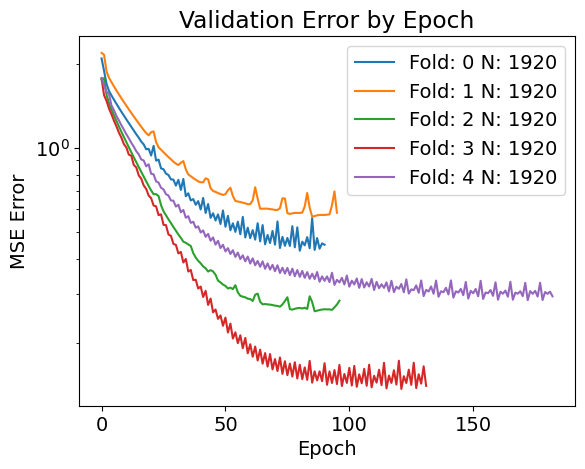

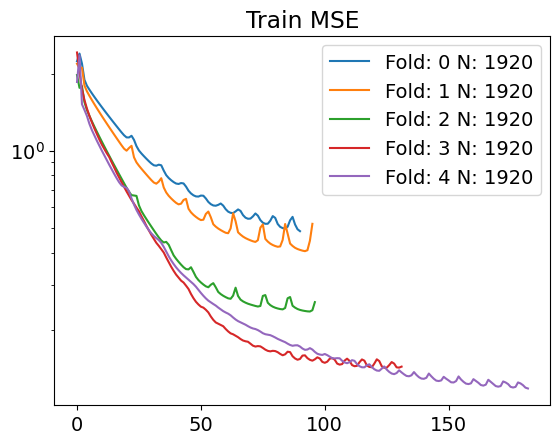

In [ ]:
from keras.optimizers.legacy import RMSprop

callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)


fit_params = {
    'epochs': 200,
    'callback': callback,
    'verbose': True
}
#, clipnorm = 0.5, clipvalue = 0.5
stored_opt = RMSprop(learning_rate = 0.002)
compile_params = {
    'optimizer': stored_opt,
    'loss': 'mse'
}

# documentation for each entry in the dictlist
# each entry represents a model layer, with structure in the following order
# 1 - number of neurons, 2 - activation function, 3 - regularization
# 3 is false if not included, object if included
L1 = 0.00
L2 = 0.01
reg = regularizers.L1L2(l1=L1, l2=L2)

model_format_dictlist = [
    {'size': 128, 'act': 'relu', 'reg': reg},
    {'size': 256, 'act': 'relu', 'reg': reg},
    {'act': 'relu'}
   ]

# divide data into training and test
testhold = math.floor(xdat.shape[0] * 0.7)
xdatv = xdat[1:testhold,:]
ydatv = ydat[1:testhold]
xtest = xdat[testhold:,:]
ytest = ydat[testhold:]
statv = statpredsIn[1:testhold,:]
stattest = statpredsIn[testhold:,:]


nn_kfold(nn_model_dictlist = model_format_dictlist,
         compile_params = compile_params,
         fit_params = fit_params,
         folds = 5,
         xdat = xdatv,
         ydat = ydatv,
         statpreds = statv,
         trainratio = 0.8,
         sametrainsize = True,
         control = False)





In [ ]:
print(statpredsIn.shape)
print(xdat.shape)
print(statv.shape)
print(stattest.shape)
print(xtest.shape)
callback = keras.callbacks.EarlyStopping(monitor='loss',patience=20)
fit_params = {
    'epochs': 200,
    'callback': callback,
    'verbose': True
}


realy,predy,lagy = evaluate_nn_architecture(nn_model_dictlist = model_format_dictlist,
                         compile_params = compile_params,
                         fit_params = fit_params,
                         xtrain = xdatv,
                         ytrain = ydatv,
                         xtest = xtest,
                         ytest = ytest,
                         stattrain = statv,
                         stattest = stattest,
                         windowsize = 1,
                         control = False)


(20578, 4)
(20578, 10)
(14403, 4)
(6174, 4)
(6174, 10)
<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x7935fa761450>>
Epoch 1/200
1/1 [==============================] - 1s 612ms/step - loss: 2.7563
Epoch 2/200
1/1 [==============================] - 0s 77ms/step - loss: 2.9967
Epoch 3/200
1/1 [==============================] - 0s 77ms/step - loss: 2.5737
Epoch 4/200
1/1 [==============================] - 0s 116ms/step - loss: 2.4160
Epoch 5/200
1/1 [==============================] - 0s 88ms/step - loss: 2.3306
Epoch 6/200
1/1 [==============================] - 0s 87ms/step - loss: 2.2679
Epoch 7/200
1/1 [==============================] - 0s 94ms/step - loss: 2.2101
Epoch 8/200
1/1 [==============================] - 0s 81ms/step - loss: 2.1559
Epoch 9/200
1/1 [==============================] - 0s 84ms/step - loss: 2.1048
Epoch 10/200
1/1 [==============================] - 0s 80ms/step - loss: 2.0561
Epoch 11/200
1/1 [==============================] - 0s

In [ ]:
print(realy.shape)
print(predy.shape)
print(lagy.shape)

(3234, 1)
(3234, 1)
(3234,)


In [ ]:
index= [predy[:,0] < -10]
print(min(predy))
predy[index[0],0]

print(xtest.min(axis = 1 ))
print(xtest[index[0],:])
print(xtest[0,:])
print(realy[index[0],0])

[-83.48183]
[-1.98141396 -0.51720899 -0.77194372 ... -0.37850636 -0.27564447
 -0.37863343]
[[-1.51035996e-01  5.48439121e-02  5.48419772e-02 -1.88477659e-01
   1.10992861e-01 -3.49934249e-02  6.98158040e-02  3.61267360e-02
  -1.13602933e-01  1.74125699e-02 -5.74546299e-02  3.61293161e-02
   7.81345576e+01 -8.21126126e+01 -3.87385288e-02 -7.24329384e-02
   8.85386997e-02 -5.37135256e-02  1.44681843e-01 -1.30374626e-03]]
[-1.11807381e-01  1.09192394e-01  1.05502187e-01  3.55250534e-02
 -2.18622648e-01  7.23603473e-02  6.86741368e-02 -1.08119097e-01
  1.05504602e-01 -3.44518390e-02  1.05499773e-01 -1.98141396e+00
 -1.30374626e-03  1.42813514e+00 -1.30374626e-03  1.46047759e-01
 -3.81424557e-02  1.09204886e-01 -7.49794991e-02 -2.03937266e-01]
[-0.02002006]


<bound method NDFrame.head of           real      pred  correct  realsign
0    -0.034452  0.029739      0.0       0.0
1     0.090797  0.043385      1.0       1.0
2     0.035552  0.007325      1.0       1.0
3     0.109277  0.009510      1.0       1.0
4    -0.255898  0.015336      0.0       0.0
...        ...       ...      ...       ...
6169 -0.001304 -0.049333      1.0       0.0
6170  0.307278 -0.033761      0.0       1.0
6171 -0.052743 -0.039081      1.0       0.0
6172 -0.052747 -0.022889      1.0       0.0
6173  0.341665 -0.030884      0.0       1.0

[6174 rows x 4 columns]>


<Figure size 640x480 with 0 Axes>

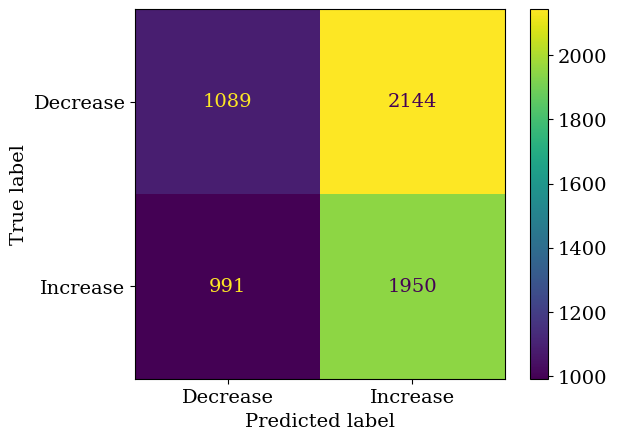

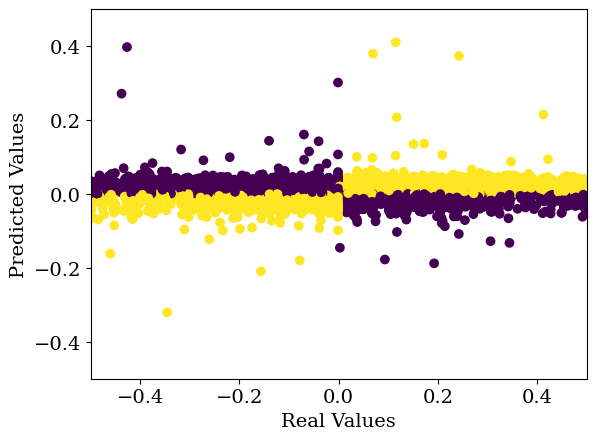

False


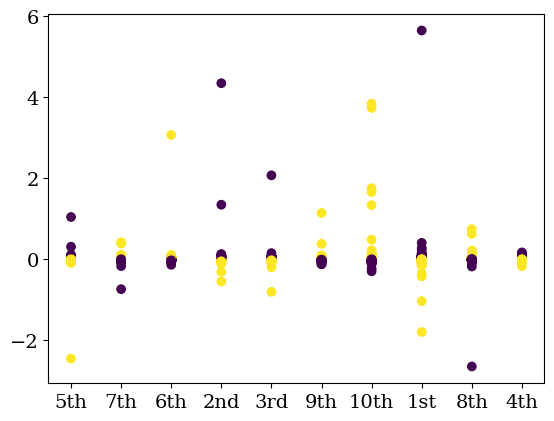

<Axes: xlabel='predcut', ylabel='Count'>

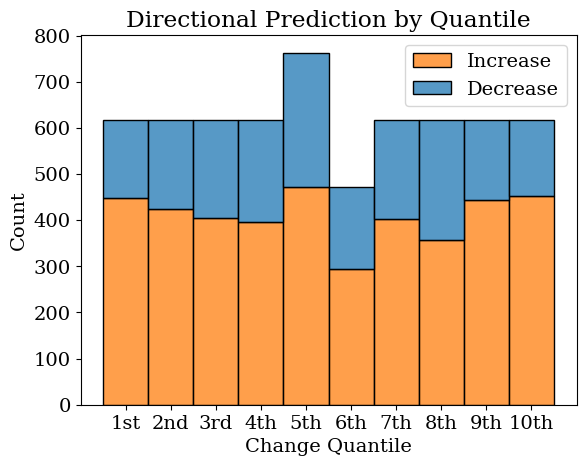

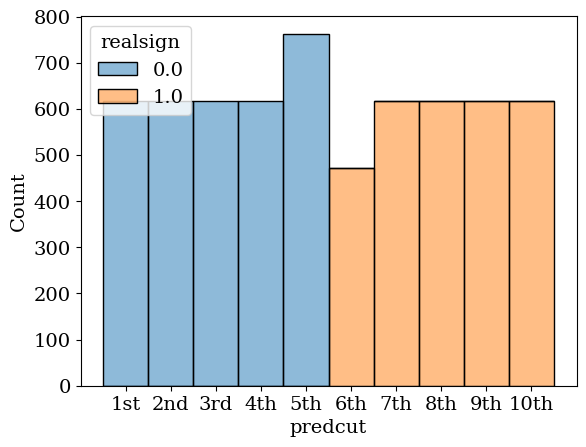

In [ ]:

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# print diagnostic plots


#print(np.subtract(realy, lagy)[0:10])

correct_dir = np.zeros(realy.shape)
real_increase = np.zeros(realy.shape)
pred_increase = np.zeros(realy.shape)

for i in range(0, predy.shape[0]):

  if realy[i,0] >= 0:
    real_increase[i,0] = 1
  if predy[i,0] >= 0:
    pred_increase[i,0] = 1

  if real_increase[i,0] == pred_increase[i,0]:
    correct_dir[i,0] = 1
  else:
    correct_dir[i,0] = 0



#print(correct_dir.astype('int').dtype)
#print(correct_dir.map({1: 'g', 0: 'r'})[0:5])

cm = confusion_matrix(real_increase, pred_increase)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Decrease', 'Increase'])
#ax=plt.subplot()
#ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);


combinedat = np.concatenate((realy, predy, correct_dir, real_increase), axis = 1)
cd = pd.DataFrame(combinedat, columns = ['real', 'pred', 'correct', 'realsign'])

print(cd.head)

plt.figure()
disp.plot()
plt.show()
plt.scatter(cd['real'], cd['pred'], c = cd['correct'].astype('category'), label = cd['correct'])
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.ylim((-0.5,0.5))
plt.xlim((-0.5,0.5))
#plt.legend()
#L=plt.legend()
#L.get_texts()[0].set_text('Incorrect')
#L.get_texts()[1].set_text('Correct')

#plt.legend()
plt.show()



#print(cd['pred'])

print(cd.isnull().values.any())

#sns.histplot(cd, x = "pred", hue = 'correct', multiple = 'stack')

cd['predcut'] = pd.qcut(cd['real'], 10, labels= ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th'], duplicates = 'raise')

plt.figure()
plt.scatter(cd['predcut'], cd['pred'], c = cd['correct'], label = cd['correct'])
plt.show()

plt.figure()
sns.histplot(cd, x = "predcut", hue = pred_increase[:,0], multiple = 'stack')
plt.xlabel("Change Quantile")
plt.legend()
plt.legend(labels = ['Increase', 'Decrease'])
plt.title("Directional Prediction by Quantile")

plt.figure()
sns.histplot(cd, x = "predcut", hue = 'realsign', multiple = 'stack', alpha = 0.5)

#print(cd['predcut'][0:10])
#dxp.count('predcut', data=cd, split='correct', stacked=True)


(3234, 1)
(3234, 1)
(3234, 1)


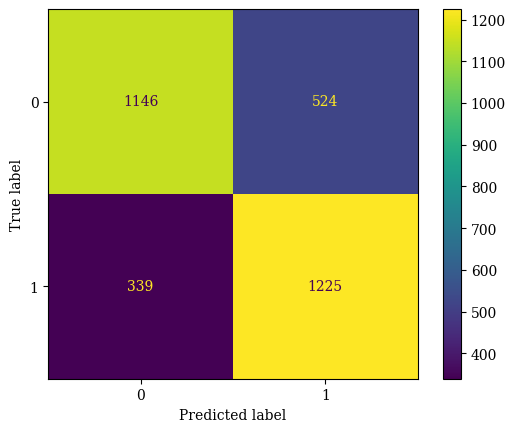

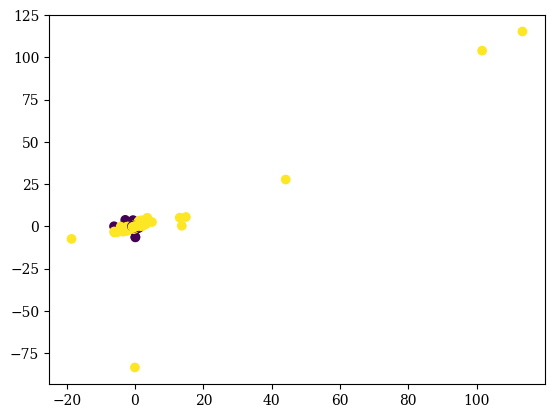

0       0.347271
1       0.656630
2      -0.298505
3      -0.401075
4      -0.641376
          ...   
3229    0.067711
3230    0.067710
3231   -0.324407
3232   -0.138021
3233   -0.288139
Name: pred, Length: 3234, dtype: float64
False
real       float64
pred       float64
correct    float64
dtype: object


TypeError: Categorical.remove_unused_categories() got an unexpected keyword argument 'inplace'

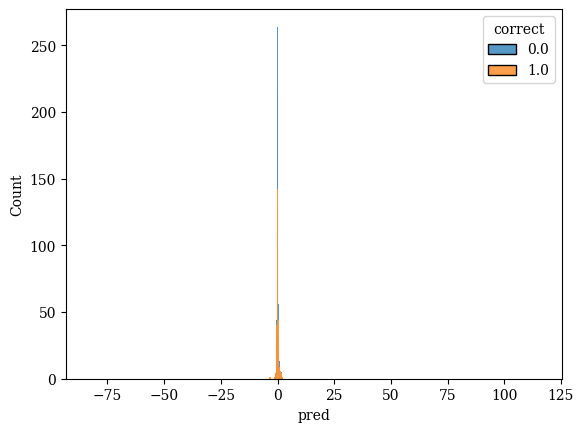

In [ ]:
# This Cell for if you aren't using a lagged series
"""
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

lagy = np.reshape(lagy, newshape = (lagy.shape[0],1))
print(lagy.shape)
print(realy.shape)

realdiff = np.subtract(realy, lagy)
preddiff = np.subtract(predy, lagy)

#print(np.subtract(realy, lagy)[0:10])

correct_dir = np.zeros(realy.shape)
real_increase = np.zeros(realy.shape)
pred_increase = np.zeros(realy.shape)

for i in range(0, predy.shape[0]):

  if realdiff[i,0] >= 0:
    real_increase[i,0] = 1
  if preddiff[i,0] >= 0:
    pred_increase[i,0] = 1

  if real_increase[i,0] == pred_increase[i,0]:
    correct_dir[i,0] = 1
  else:
    correct_dir[i,0] = 0



#print(correct_dir[0:10])
print(correct_dir.shape)

cm = confusion_matrix(real_increase, pred_increase)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, )

disp.plot()


plt.show()
plt.scatter(realdiff, preddiff, c = correct_dir)
#ax.legend()

plt.show()


combinedat = np.concatenate((realdiff, preddiff, correct_dir), axis = 1)
cd = pd.DataFrame(combinedat, columns = ['real', 'pred', 'correct'])


print(cd['pred'])

print(cd.isnull().values.any())

sns.histplot(cd, x = "pred", hue = 'correct', multiple = 'stack')

print(cd.dtypes)
cd['predcut'] = pd.qcut(cd['pred'], 10, labels= ['1','2','3','4','5','6','7','8','9','10'])
dxp.count('predcut', data=cd, split='correct', stacked=True, normalize='predcut')


"""


In [ ]:
#print(cd['predcut'])
index = cd['predcut']== '10'
print(xtest[index,:].shape)

evaluate_nn_architecture(nn_model_dictlist = model_format_dictlist,
                         compile_params = compile_params,
                         fit_params = fit_params,
                         xtrain = xdatv,
                         ytrain = ydatv,
                         xtest = xtest[index,:],
                         ytest = ytest[index,:],
                         stattrain = statv,
                         stattest = stattest[index,:],
                         windowsize = 1,
                         control = False)



(324, 20)
Epoch 1/200
1/1 [==============================] - 0s 412ms/step - loss: 1.7464
Epoch 2/200
1/1 [==============================] - 0s 15ms/step - loss: 4.5749
Epoch 3/200
1/1 [==============================] - 0s 14ms/step - loss: 2.1619
Epoch 4/200
1/1 [==============================] - 0s 15ms/step - loss: 1.9674
Epoch 5/200
1/1 [==============================] - 0s 13ms/step - loss: 1.5401
Epoch 6/200
1/1 [==============================] - 0s 15ms/step - loss: 1.4388
Epoch 7/200
1/1 [==============================] - 0s 14ms/step - loss: 1.4228
Epoch 8/200
1/1 [==============================] - 0s 11ms/step - loss: 1.4272
Epoch 9/200
1/1 [==============================] - 0s 11ms/step - loss: 1.4364
Epoch 10/200
1/1 [==============================] - 0s 8ms/step - loss: 1.4436
Epoch 11/200
1/1 [==============================] - 0s 15ms/step - loss: 1.4435
Epoch 12/200
1/1 [==============================] - 0s 11ms/step - loss: 1.4354
Epoch 13/200
1/1 [=====================

(array([[-1.85617737e-01],
        [-6.63325788e-01],
        [ 6.65803929e-01],
        [ 2.02080837e-01],
        [-9.35158229e-02],
        [ 1.39361868e+00],
        [-5.19015910e-01],
        [ 5.54439060e-01],
        [ 1.85212748e-01],
        [ 2.98730168e-01],
        [ 3.62194098e-02],
        [-2.98261261e-01],
        [ 3.63360082e-02],
        [-3.03067359e-01],
        [ 7.44078083e-02],
        [ 3.77411542e-01],
        [ 5.26798445e-01],
        [ 2.65061312e-01],
        [ 2.27253652e-01],
        [-7.22956992e-01],
        [ 1.31394049e-01],
        [-2.81838685e-01],
        [ 4.92053686e-01],
        [-1.11809070e-01],
        [-4.27954604e-01],
        [-1.30374626e-03],
        [ 2.28980408e-01],
        [ 2.30131352e-01],
        [-8.07564781e-01],
        [ 1.52587359e-01],
        [ 5.33216659e-01],
        [ 4.82385607e-01],
        [-7.77601957e-02],
        [ 1.09384870e-01],
        [-1.91427289e-01],
        [ 4.35508375e-01],
        [-6.42505605e-01],
 

In [ ]:
evaluate_nn_architecture(nn_model_dictlist = model_format_dictlist,
                         compile_params = compile_params,
                         fit_params = fit_params,
                         xtrain = xdatv,
                         ytrain = ydatv,
                         xtest = xtest,
                         ytest = ytest,
                         stattrain = statv,
                         stattest = stattest,
                         windowsize = 1,
                         control = False)